In [1]:
### Library Imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")


In [2]:
### Import S&P500 Data
def get_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start_date, end_date)['Adj Close']
    
    return data

### Return Stock Data
tickers = ['^GSPC']  # Ticker symbol for the S&P 500
start_date = '2019-01-01'
end_date = '2024-01-01'
stock_data = get_data(tickers, start_date, end_date)
print(stock_data.tail())

# Get most recent stock price
s_0 = stock_data['^GSPC'].iloc[-1]
print('The most recent stock price is: ', round(s_0, 4))

[*********************100%%**********************]  1 of 1 completed

                  ^GSPC
Date                   
2023-12-22  4754.629883
2023-12-26  4774.750000
2023-12-27  4781.580078
2023-12-28  4783.350098
2023-12-29  4769.830078
The most recent stock price is:  4769.8301


In [3]:
### Set input parameters
# Option parameters
T = 1.0          # Time to maturity (in years)
r = 0.05         # Risk-free rate
n_simulations = 100  # Number of simulations
n_steps = 252    # Number of time steps (252 trading days in a year)
dt = T / n_steps # Time increment

# Determine strike price
k = s_0 * 1.05 # lookback_call or barrier_call (5% increase over current stock price (bullish))
print('The computed option strike price is:', round(k, 4))

# Compute Sigma - stddev * sqrt(252)
daily_rets = stock_data.pct_change().dropna()
#print(daily_rets.tail())
sigma = daily_rets['^GSPC'].std() * np.sqrt(252)
print('The computed sigma is: ', round(sigma, 4))


The computed option strike price is: 5008.3216
The computed sigma is:  0.2132


In [4]:
### Simulate Price Paths
def price_paths(S0, T, r, sigma, dt, n_steps, n_simulations):
    # Initialize the array for storing simulated stock price paths
    S = np.zeros((n_steps + 1, n_simulations))
    S[0] = S0
    # Set the seed for reproducibility
    np.random.seed(42)
    # Simulate price paths
    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(n_simulations)
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return S

### Display Price Paths
paths = price_paths(s_0, T, r, sigma, dt, n_steps, n_simulations)
print(paths.shape)

(253, 100)


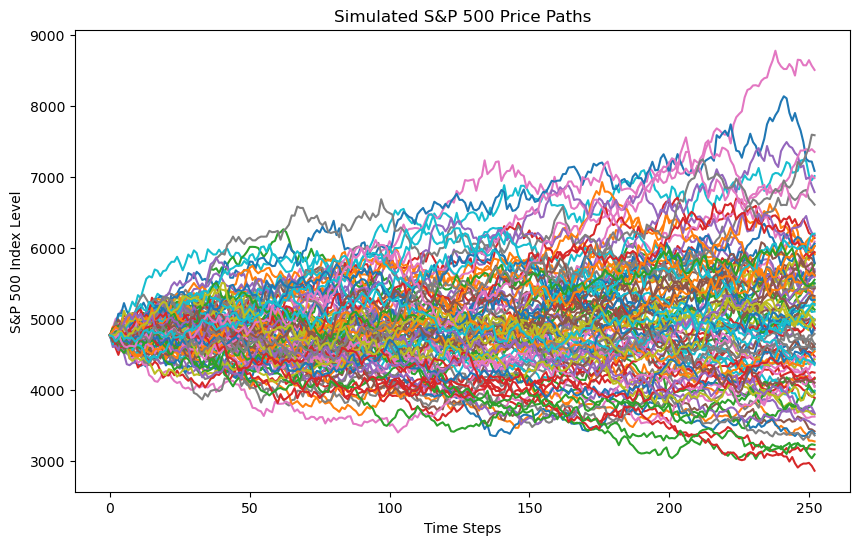

In [5]:
### Plot Price Paths
def plot_paths(price_paths, n_simulations):
    # Plot some simulated paths
    plt.figure(figsize = (10, 6))
    # Iterate 
    for t in range(n_simulations):
        plt.plot(price_paths[:, t])
    
    plt.title('Simulated S&P 500 Price Paths')
    plt.xlabel('Time Steps')
    plt.ylabel('S&P 500 Index Level')
    plt.show()

plot_paths(paths, n_simulations)

In [6]:
### Calculate Avg Asset Price
def avg_price(paths, n_simulations):
    # Array initialization
    avg_path = []
    # Iterate to calculate avg price over time
    for t in range(n_simulations):
        avg_path.append(paths[:, t].mean())

    return avg_path

avg_price_path = avg_price(paths, n_simulations)
print('Last 5 average computed price path values:')
print(avg_price_path[-5:])
print('The average computed price at the last period is: $', round(avg_price_path[-1], 4))
#print(len(avg_price_path))


Last 5 average computed price path values:
[4822.434294535865, 5815.055066888631, 5552.164323997555, 4891.586367104114, 4905.142454952528]
The average computed price at the last period is: $ 4905.1425


In [7]:
### Calculate option payoff for Barrier Options
def barrier_payoffs(S, K, H):
    # Compute Min/Max values
    M_T = np.max(S, axis=0)
    m_T = np.min(S, axis=0)
    # Init payoff array
    payoffs = np.zeros(S.shape[1])
    
    # Outer loop iterates over each column (each simulation path)
    for i in range(S.shape[1]):
        # Up-and-out
        ''' 
        If H exceeds the current stock price S(0) and also exceeds the strike price K, we could have an up-and-out European call option 
        The payoff would be as for a normal call option unless the stock price gets as high as H, in which case the payoff is zero
        '''
        if H > S[0, 0]:  
            if M_T[i] > H:
                payoffs[i] = 0
            else:
                if S[-1, i] < K:
                    payoffs[i] = 0
                else:
                    payoffs[i] = S[-1, i] - K
        # Down-and-out
        ''' 
        Similarly, for a down-and-out European put option uses barrier at H < S(0) (and H < K)
        '''
        elif H < S[0, 0]:  
            if m_T[i] <= H:
                payoffs[i] = 0
            else:
                if S[-1, i] >= K:
                    payoffs[i] = 0
                else:
                    payoffs[i] = K - S[-1, i]
                    
    return payoffs


SyntaxError: invalid syntax (3920497948.py, line 28)

In [ ]:
### Calculate option payoff for Lookback Options



In [ ]:
### Calculate option payoff for Asain Options

